# Exercise 9: PyTorch & Gradient Descent

## We would like to solve the following kind of problems:  

- Given is a **labeled** dataset $D=\{(x_i,y_i)\}_{i=1}^N \subseteq X\times Y$ and a **parametrized differentiable** function $f_\theta: X\rightarrow Y$.   
- We measure the performance of our function using a **differentiable** loss $L: Y\times Y \rightarrow \mathbb{R}$.  
- We would like to find the optimal parameters/weights for $\theta$ that minimize the following error:

$$E = \sum_{i=1}^N L(y_i, f_\theta(x))$$

A (local) optimum can be found using gradient descent: 
- initialize weights $\theta_0$
- until convergence of E do:
    \begin{align}\theta_{n+1} &= \theta_n - \lambda \nabla_\theta E  \\
    &= \theta_n - \lambda \sum_{i=1}^N \nabla_\theta L(y_i, f_\theta(x))  \end{align}

## The following difficulties arise when implementing this procedure yourself
- The computation of the gradient varies when:
    - changing the loss-function
    - changing the parametric function
    - changing the update rule (different optimizations Adam, Adagrad, Rprop) 
    - changing dimensionality/shape of data
- utilizing performance improvements
    - multithreading
    - GPU
    - numerical calculations (linear algebra, array operations, etc.)

# PyTorch

This exercise is based on the following tutorial: https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

In [1]:
import torch
import numpy as np

In [2]:
x = torch.cuda.device(0)
torch.cuda.get_device_name(0)

'GeForce RTX 2060'

## Tensors
Tensor provide the basic data structure. Similar to numpy they describe a multidimensional array.  
All of PyTorch's operations are based around them.

### Initialization

In [3]:
# from data
data = [[1, 2],[3, 4]]
x = torch.tensor([[1,2],[3,4]])

# from numpy
np_array = np.array(data)
x = torch.from_numpy(np_array)

# from other tensors
x_ones = torch.ones_like(x) # retains the properties of x_data
x_rand = torch.rand_like(x, dtype=torch.float) # overrides the datatype of x_data

# with initialized values
shape = (3,5,6)
rand_tensor = torch.rand((3,5,6)) # random values 
ones_tensor = torch.ones(shape)   # constant value of 1
zeros_tensor = torch.zeros(shape) # constan value of 0

In [4]:
tensor = torch.rand(3,4)

print(f"Shape of tensor: {tensor.shape}")
print(f"Datatype of tensor: {tensor.dtype}")
print(f"Device tensor is stored on: {tensor.device}")

Shape of tensor: torch.Size([3, 4])
Datatype of tensor: torch.float32
Device tensor is stored on: cpu


### Tensor operation

In [5]:
# numpy-like slicing
tensor = torch.ones(4, 4)
tensor[:,1] = 0
print(tensor)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


In [6]:
tensor = torch.ones(4, 4)
# joining tensors
t1 = torch.cat([tensor, tensor, tensor], dim=1)
print(t1.size())

torch.Size([4, 12])


In [7]:
# splitting tensors
tensor_list = torch.split(t1, 4, dim=1) # split tensor along 0th dimension in chunks of size 4 
print(tensor_list[0].size())

torch.Size([4, 4])


In [8]:
# stack tensors along new dimension
t2 = torch.stack([tensor, tensor, tensor], dim=1)
print(t2.size())

torch.Size([4, 3, 4])


In [9]:
# unstack tensors
tensor_list = torch.unbind(t2, dim =1)
print(tensor_list[0].size())

torch.Size([4, 4])


In [10]:
# reshape tensor
print(tensor.reshape(2,2,-1).size())

torch.Size([2, 2, 4])


### Math operations

In [11]:
x = torch.ones(5,5)

# Addition
print(f"x + x ={x + x}")

# Elementwise multiplication
print(f"x * x ={x * x}")


# Matrix Multiplication
print(f"x @ x ={x @ x}")

x + x =tensor([[2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.]])
x * x =tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])
x @ x =tensor([[5., 5., 5., 5., 5.],
        [5., 5., 5., 5., 5.],
        [5., 5., 5., 5., 5.],
        [5., 5., 5., 5., 5.],
        [5., 5., 5., 5., 5.]])


In [12]:
x = torch.rand((4,4))
# elementwise operations
torch.exp(x)
torch.cos(x)
torch.sin(x)
x**10 # elementwise power operation

tensor([[1.5872e-11, 1.3864e-05, 8.4228e-13, 2.2132e-01],
        [8.3505e-06, 5.6054e-02, 2.1874e-10, 3.7919e-11],
        [2.7475e-13, 5.9895e-04, 1.0396e-01, 3.7812e-04],
        [3.1007e-03, 3.7299e-02, 4.8442e-09, 1.8009e-01]])

## Autograd
PyTorch and other **Automatic differentiation** frameworks provide an easy way to compute gradients.  
Specifically, they provide an efficient implementation of the **Backpropagation Algorithm**

 

Let's create an artificial dataset with a linear model:$$ y_i = w^Tx_i + b$$

In [13]:
w = torch.tensor([[0.5,-1.0]])

bias = 0
b = torch.tensor([bias])

N = 1000
X_gt = torch.rand((2,N))
Y_gt = w@X_gt + b
print(Y_gt.size())

torch.Size([1, 1000])


Let's assume we didn't know the parameters of $w$ and $b$. We are only given $X$ and $Y$ and the model class.
We want to estimate the parameters using gradient descent.

In [18]:
from torch.autograd import Variable
import time

eps = 0.0001
lr = 0.1


# Initialize the parameters
w = torch.rand(1,2, requires_grad=True)
#b = torch.rand(1, requires_grad=True)

steps = []

while True: # Until convergence
    
    Y_est = w@X_gt + b
    error = torch.mean(((Y_est-Y_gt)**2))
    error.backward()
    
    with torch.no_grad():
        w = w - lr * w.grad
        #b = b - lr * b.grad
    print(error.item(), end='\r')
    w.requires_grad = True
    #b.requires_grad = True
    
    steps.append(w.detach().numpy())
    if error.item() < eps:
        break
        
steps = np.array(steps).reshape((-1,2))
print("Estimation of w: ",w)
#print("Estimation of b:",b)

print("Number of steps:", len(steps))

Estimation of w:  tensor([[ 0.4752, -0.9756]], requires_grad=True)
Number of steps: 220


(40, 40) (40, 40)


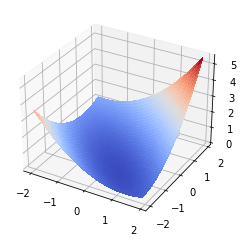

In [15]:
from numpy import exp,arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
import matplotlib.pyplot as plt
from matplotlib import cm
# the function that I'm going to plot


@np.vectorize
def error(x,y):
    w = np.array([x,y])
    Y_est = w@X_gt.numpy() + bias
    return ((Y_est-Y_gt.numpy())**2).mean()
 
x = arange(-2.0,2.0,0.1)
y = arange(-2.0,2.0,0.1)
X,Y = meshgrid(x, y) # grid of point

print(X.shape,Y.shape)

Z = error(X, Y) # evaluation of the function on the grid

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)


#im = imshow(Z,cmap=cm.RdBu) # drawing the function
# adding the Contour lines with labels
#cset = contour(Z,arange(-1,1.5,0.2),linewidths=2,cmap=cm.Set2)
#clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
#colorbar(im) # adding the colobar on the right
# latex fashion title

show()

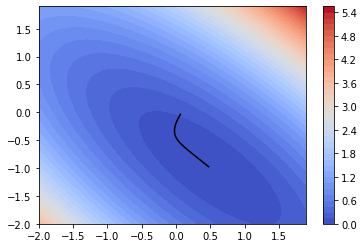

In [16]:
plt.contourf(X, Y, Z, 50, cmap=cm.coolwarm)
plt.plot(steps[:,0],steps[:,1], color = "black")
colorbar()